# Predicting Raisin Classes Using PySpark

*Raiden Han*


## Introduction

This project will use machine learning methods - supervised learning especially - to learn from the raisin grains' morphological features and predict the classes, either Kecimen or Besni. The dataset is from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Raisin+Dataset).

These data are the results of images of Kecimen and Besni raisin varieties grown in Turkey. These images were subjected to various pre-processing stages, and previous researchers extracted seven morphological features. This project will do EDA, build machine learning models in PySpark, and predict the class.

I'll import the necessary packages here for later use.

In [1]:
# Import the modules and functions
import warnings
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA, PolynomialExpansion, StringIndexer, \
    StandardScaler, SQLTransformer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
    RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Ignore all warnings for better readability
warnings.filterwarnings('ignore')

# Create a new Spark session
spark = SparkSession.builder.master(
    "local[4]").appName("my_app").getOrCreate()

# Configurate the Spark session
ps.set_option("compute.default_index_type", "distributed")
ps.set_option("plotting.backend", "matplotlib")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Supervised Learning Idea and Data Split

### Supervised Learning

Supervised learning is a subclass of machine learning. The basic idea is to build a model based on given features and labels - either a numeric or a categorical variable - and predict the labels solely on features. For this project, the features are the seven morphological constituents, and the label is the raisin grains' class. This project will include logistic regression, decision tree, and random forest models.

### Data Split

Since the ultimate purpose is to predict the raisin grain's class on unseen data when training the model, I will split the dataset into training and test sets in a ratio of 80% to 20%, correspondingly. I'll use the training set to analyze the features' distributions and relationships with the class and take the test set to evaluate the model's performance on unseen data.

Also, I'll introduce cross-validation to compare different models on the training set. Specifically, I'll use the area under the curve (AUC) to evaluate the performance. To avoid our models only fitting the given data and losing the generalization ability, called overfitting, and to choose the best hyperparameters when designing the models, I'll split the training set into five chunks. In each iteration, the model will learn from four chunks and make predictions on the other. After that, I will choose the model with the maximum AUC under each category for the final test.

In [2]:
# Read the local data
data = ps.read_excel('data/Raisin_Dataset.xlsx').to_spark()
# Split the data into training and test sets
train, test = data.randomSplit([0.8, 0.2], seed=82)
train.show(5)

+-----+---------------+---------------+------------+----------+-----------+---------+-------+
| Area|MajorAxisLength|MinorAxisLength|Eccentricity|ConvexArea|     Extent|Perimeter|  Class|
+-----+---------------+---------------+------------+----------+-----------+---------+-------+
|25387|     225.629541|     144.618672| 0.767577386|     26139|0.678144032|  619.074|Kecimen|
|33565|    261.5543311|    167.7084908| 0.767374275|     35794| 0.68155052|  751.413|Kecimen|
|35237|    267.5537786|    173.5251032| 0.761162183|     37418|0.706832223|  750.909|Kecimen|
|36145|    280.7576527|    166.5935504| 0.804928834|     37401|0.812265444|  747.161|Kecimen|
|38585|    274.4450783|    180.9575592| 0.751829118|     39926|0.696593309|  762.439|Kecimen|
+-----+---------------+---------------+------------+----------+-----------+---------+-------+
only showing top 5 rows



### Classification Metric: Area Under the Curve (AUC)

Before diving deeper into the metric, I'll give some other metrics for a classification problem. 
- true positive (TP): A test result that correctly indicates the presence of a condition or characteristic
- true negative (TN): A test result that correctly indicates the absence of a condition or characteristic
- false positive (FP): A test result that wrongly indicates that a particular condition or attribute is present
- false negative (FN): A test result that wrongly indicates that a particular condition or attribute is absent

In this project, I'll define Kecimen raisin as 1 and Besni raisin as 0. Therefore, the above metrics represent
- true positive (TP): Correctly classify a Kecimen raisin
- true negative (TN): Correctly classify a Besni raisin
- false positive (FP): Wrongly classify a Besni raisin as a Kecimen raisin
- false negative (FN): Wrongly classify a Kecimen raisin as a Besni raisin

From there, we can further define 
$$\text{true positive rate }(TPR)=\frac{TP}{TP+FN},$$
$$\text{false positive rate }(FPR)=\frac{FP}{FP+TN}.$$

Because our model will return a probability for one class, by altering the classification threshold, we'll get a curve of TPR versus FPR called receiver operating characteristic (ROC), as shown below. For example, a return of 0.4 indicates that the probability of a Kecimen one is 60% and a Besni one is 40%. If our threshold is 0.5, the model will classify the raisin as Kecimen. But if the threshold is 0.3, our model will then classify it as Besni.

<p align="center">
  <img width="400" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1024px-Roc_curve.svg.png">
</p>


AUC is the area under the ROC curve. In machine learning practice, AUC has been shown to be an extremely effective classifier measure. The metric takes into account accuracy while providing a better comparison of model performance on unbalanced datasets.

## Exploratory Data Analysis (EDA)

This section will explore the features' distributions and their relationships with the label. To begin with, I will convert the string labels to integers. Also, for better readability and easier plotting, I will convert the spark-sql DataFrame to a pandas-on-spark DataFrame.

In [3]:
# Create an indexer
indexer = StringIndexer(inputCol='Class', outputCol='label')
train_indexed = indexer.fit(train).transform(train)
# Convert the spark-sql DataFrame to a pandas-on-spark DataFrame
train_df = train_indexed.pandas_api()
train_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class,label
0,25387,225.629541,144.618672,0.767577,26139,0.678144,619.074,Kecimen,1.0
1,33565,261.554331,167.708491,0.767374,35794,0.681551,751.413,Kecimen,1.0
2,35237,267.553779,173.525103,0.761162,37418,0.706832,750.909,Kecimen,1.0
3,36145,280.757653,166.593550,0.804929,37401,0.812265,747.161,Kecimen,1.0
4,38585,274.445078,180.957559,0.751829,39926,0.696593,762.439,Kecimen,1.0


First, I will show the statistics summary. 

In [4]:
train_df.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,label
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,87872.439607,429.994247,255.218141,0.779392,91256.057584,0.699629,1165.729209,0.492978
std,39054.323102,114.919773,50.444025,0.090990,40768.512811,0.052924,272.577274,0.500302
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000,0.000000
25%,59370.000000,345.315246,219.684365,0.740009,61585.000000,0.671900,966.493000,0.000000
50%,78982.000000,408.189922,247.716596,0.795682,81718.000000,0.707308,1126.518000,0.000000
75%,104468.000000,494.055192,280.343741,0.841966,108072.000000,0.735097,1299.386000,1.000000
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000,1.000000


As shown above, the scales are significantly different for these features. Since I want to include the polynomial and interaction terms and add a penalty term to the logistic regression model later to improve the model performance and avoid overfitting, it is essential to standardize these features before inputting.

From statistic theories, we know that it would facilitate the model's performance if we have normal-distributed features. Therefore, I will plot histograms for all features to visualize their distributions.

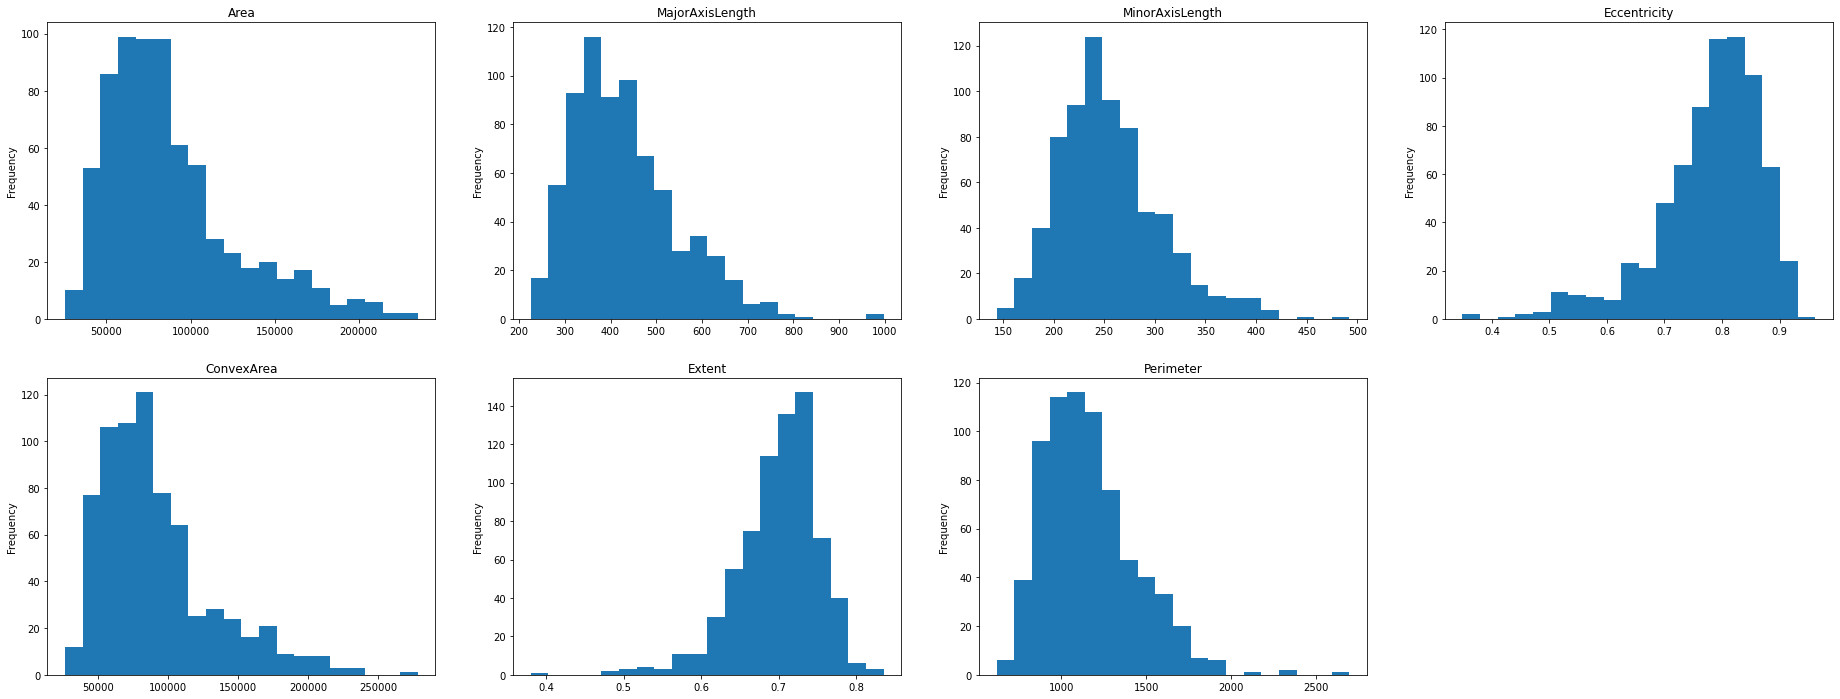

In [5]:
# Construct a feature list
features = train_df.columns.to_list()
features.remove('Class')
features.remove('label')
# Plot the distribution for all features
fig = plt.figure(figsize=(32, 12))
i = 241  # location identifier
for feature in features:
    ax = fig.add_subplot(i)
    train_df[feature].plot(kind='hist', bins=20, ax=ax)
    ax.set_title(feature)
    i += 1
plt.show()

These figures show that the area, major axis length, minor axis length, convex area, and perimeter features are right-skewed. We usually take cube root, square root, or logarithm to transform these features into symmetric distributions. Here, I will plot the transformed shapes for each feature.

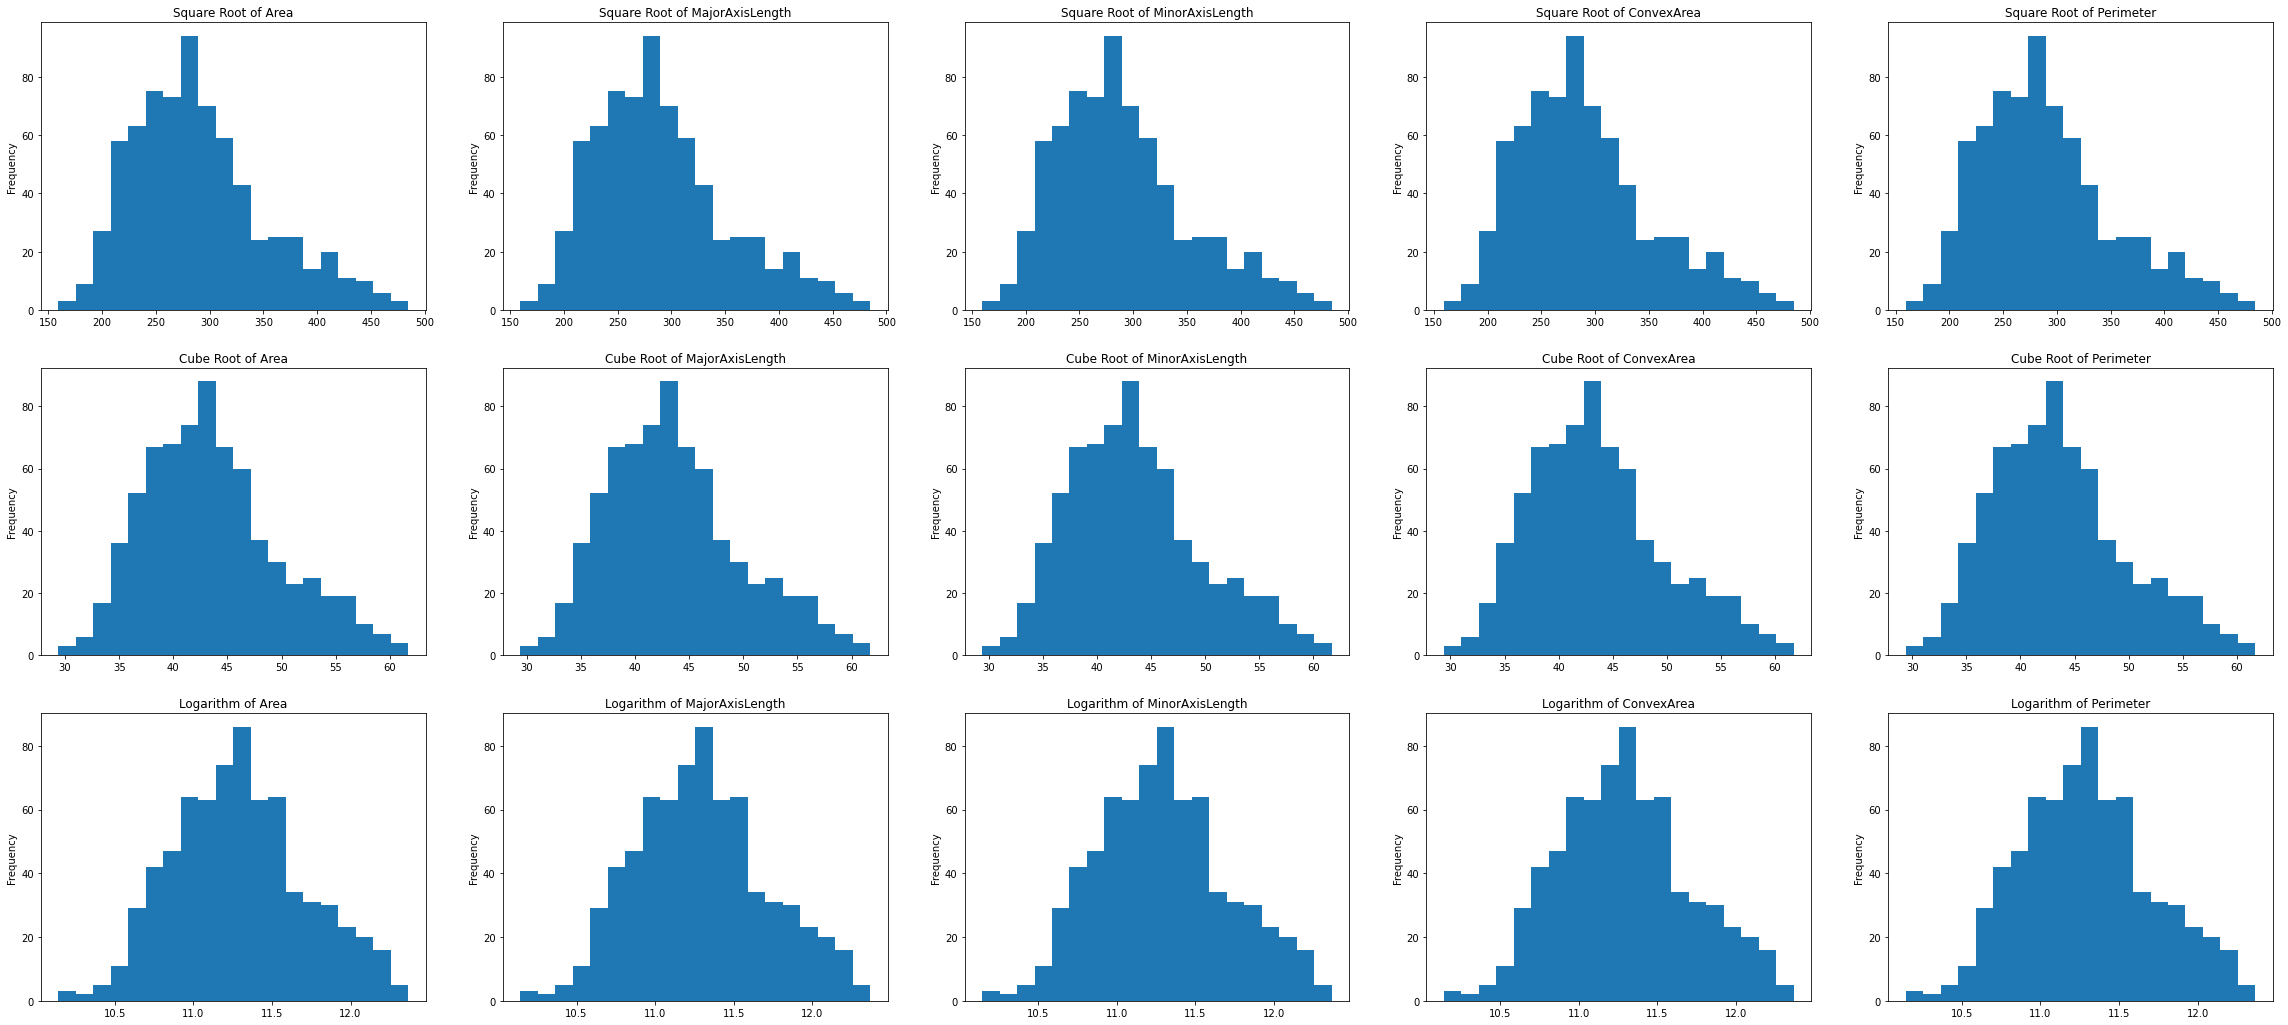

In [6]:
right_skewed_features = ['Area', 'MajorAxisLength', 'MinorAxisLength',
                         'ConvexArea', 'Perimeter']
# Plot
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(40, 18))
for i in range(len(right_skewed_features)):
    train.select((F.pow(F.col('Area'), 1 / 2)).alias(
        'squareRoot')).pandas_api().plot(
        kind='hist', bins=20, ax=ax[0, i], legend=False)
    train.select((F.pow(F.col('Area'), 1 / 3)).alias(
        'cubeRoot')).pandas_api().plot(
        kind='hist', bins=20, ax=ax[1, i], legend=False)
    train.select((F.log(F.col('Area'))).alias(
        'logarithm')).pandas_api().plot(
        kind='hist', bins=20, ax=ax[2, i], legend=False)
    ax[0, i].set_title(f'Square Root of {right_skewed_features[i]}')
    ax[1, i].set_title(f'Cube Root of {right_skewed_features[i]}')
    ax[2, i].set_title(f'Logarithm of {right_skewed_features[i]}')
plt.show()

We can tell from the above figures that almost for all features, the logarithm is the best method for transformation. Therefore, I will take the logarithm before putting them into the model. 

Also, I have two left-skewed features. Since the common way to transform them is to take a square, and I am going to introduce the polynomial and interaction terms later, I will not do any transformation for them here.

Before proceeding to the next step, I want to grasp a basic idea of how good these features are in identifying the raisin class and the relationships between features. I will pair these features and make scatter plots for a more straightforward understanding.

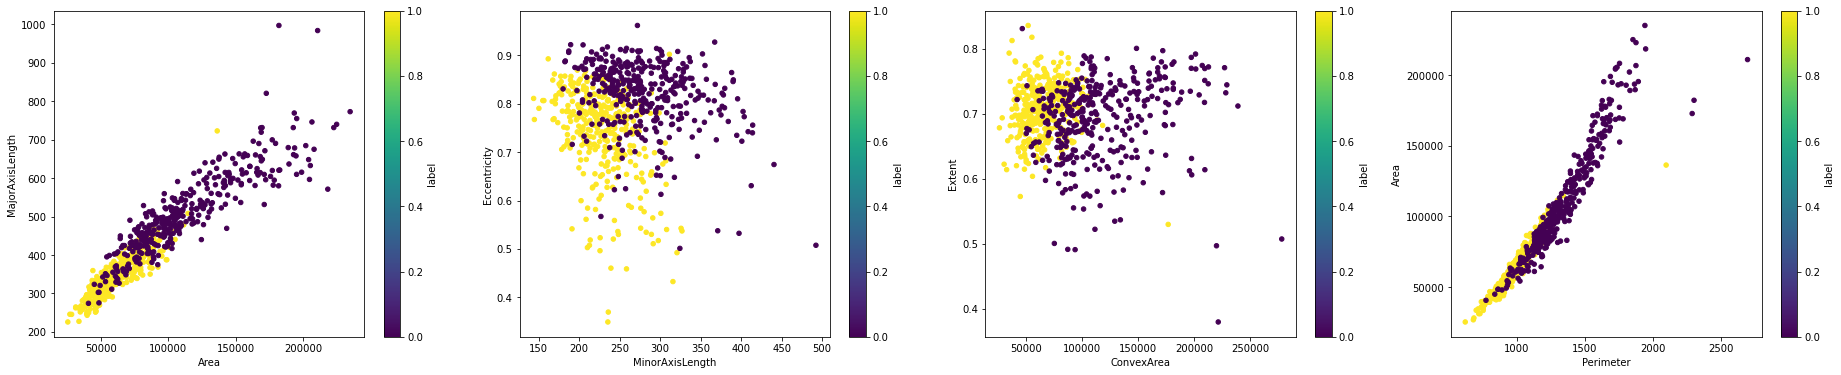

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(32, 6))
for i in range(0, len(features), 2):
    # Add an extra index to deal with the boundary
    j = i + 1
    if i == len(features) - 1:
        j = 0
    # Plot
    train_df.plot(kind='scatter', x=features[i], y=features[j],
                  c='label', cmap='viridis', ax=ax[i // 2])
plt.show()

In all four figures above, there is some degree of clustering in the distribution of raisin classes, as in Figures 1, 2, and 4, where Kecimen raisins are distributed in the lower left. Therefore, we should expect our model to have superior performance. In addition, Figures 1 and 4 show strong multicollinearity between features. I will use the PCA method to address this issue in the model building section.

## Feature Engineering

This section will apply logarithm to the features mentioned above, add the polynomial and interaction terms to the feature pool, standardize these features and use the PCA method to eliminate multicollinearity.

### Logarithm Transformation

As talked above, I'll first take the logarithm of the five features for more symmetric distributions.

In [8]:
sqlTrans = SQLTransformer(
    statement="""
    SELECT LOG(Area) as logArea, log(MajorAxisLength) as logMajorAxisLength,
    LOG(MinorAxisLength) as logMinorAxisLength, Eccentricity, 
    LOG(ConvexArea) as logConvexArea, Extent, LOG(Perimeter) as logPerimeter,
    Class, label
    FROM __THIS__""")
train_log = sqlTrans.transform(train_indexed)
train_log.show(5)

+------------------+------------------+------------------+------------+------------------+-----------+-----------------+-------+-----+
|           logArea|logMajorAxisLength|logMinorAxisLength|Eccentricity|     logConvexArea|     Extent|     logPerimeter|  Class|label|
+------------------+------------------+------------------+------------+------------------+-----------+-----------------+-------+-----+
|10.141992510963037|5.4188944552004035| 4.974100430018986| 0.767577386|10.171183730899397|0.678144032|6.428224813196857|Kecimen|  1.0|
|10.421239136372852| 5.566642029037191| 5.122227298435955| 0.767374275|10.485535560577354| 0.68155052|6.621955434028269|Kecimen|  1.0|
|10.469851945892822| 5.589320587625255| 5.156322275952455| 0.761162183|10.529907151045364|0.706832223| 6.62128447265127|Kecimen|  1.0|
|10.495293905434398| 5.637491851305829| 5.115557015898137| 0.804928834|10.529452721013085|0.812265444| 6.61628069069162|Kecimen|  1.0|
|10.560618878891704| 5.614751161878278| 5.1982625242131

In particular, I would like to explore here whether logarithmic operations solve the problem of multicollinearity. I will pick two features with obvious multicollinearity from the above - area and principal axis length - and draw their logarithmic scatterplots.

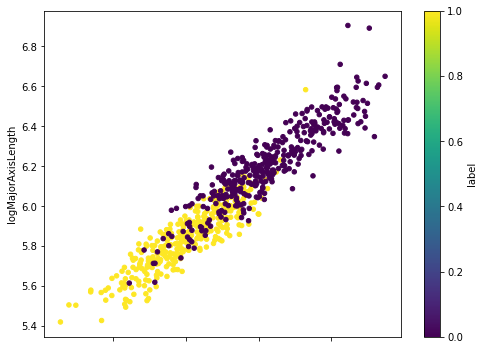

In [9]:
train_log.select(['logArea', 'logMajorAxisLength', 'label']).pandas_api().plot(
    kind='scatter', x='logArea', y='logMajorAxisLength',
    c='label', cmap='viridis', figsize=(8, 6))
plt.show()

As shown above, even after the logarithmic operation, there is still an extremely strong linear correlation between the two variables, implying the necessity of the PCA method.

### Adding Degree-2 Terms

Next, I want to add degree-2 terms to the feature pool to maximize the information contained in the original features. For example, if we denote the transformed original features as $x_1,\dots,x_7$, the expanded feature pool will have $x_1, \dots, x_7, x_1^2, \dots, x_7^2, x_1x_2, x_1x_3, \dots, x_6x_7$.

Because the ml.feature function is vector-based, I will assemble all features into a vector initially.

In [10]:
assembler = VectorAssembler(
    inputCols=['logArea', 'logMajorAxisLength', 'logMinorAxisLength',
               'Eccentricity', 'logConvexArea', 'Extent', 'logPerimeter'],
    outputCol="features")
train_assembled = assembler.transform(train_log)
train_assembled.show(5)

+------------------+------------------+------------------+------------+------------------+-----------+-----------------+-------+-----+--------------------+
|           logArea|logMajorAxisLength|logMinorAxisLength|Eccentricity|     logConvexArea|     Extent|     logPerimeter|  Class|label|            features|
+------------------+------------------+------------------+------------+------------------+-----------+-----------------+-------+-----+--------------------+
|10.141992510963037|5.4188944552004035| 4.974100430018986| 0.767577386|10.171183730899397|0.678144032|6.428224813196857|Kecimen|  1.0|[10.1419925109630...|
|10.421239136372852| 5.566642029037191| 5.122227298435955| 0.767374275|10.485535560577354| 0.68155052|6.621955434028269|Kecimen|  1.0|[10.4212391363728...|
|10.469851945892822| 5.589320587625255| 5.156322275952455| 0.761162183|10.529907151045364|0.706832223| 6.62128447265127|Kecimen|  1.0|[10.4698519458928...|
|10.495293905434398| 5.637491851305829| 5.115557015898137| 0.804

Now I can add the degree-2 terms.

In [11]:
px = PolynomialExpansion(degree=2,
                         inputCol='features', outputCol='polyFeatures')
train_poly = px.transform(train_assembled)
train_poly.show(5)

+------------------+------------------+------------------+------------+------------------+-----------+-----------------+-------+-----+--------------------+--------------------+
|           logArea|logMajorAxisLength|logMinorAxisLength|Eccentricity|     logConvexArea|     Extent|     logPerimeter|  Class|label|            features|        polyFeatures|
+------------------+------------------+------------------+------------+------------------+-----------+-----------------+-------+-----+--------------------+--------------------+
|10.141992510963037|5.4188944552004035| 4.974100430018986| 0.767577386|10.171183730899397|0.678144032|6.428224813196857|Kecimen|  1.0|[10.1419925109630...|[10.1419925109630...|
|10.421239136372852| 5.566642029037191| 5.122227298435955| 0.767374275|10.485535560577354| 0.68155052|6.621955434028269|Kecimen|  1.0|[10.4212391363728...|[10.4212391363728...|
|10.469851945892822| 5.589320587625255| 5.156322275952455| 0.761162183|10.529907151045364|0.706832223| 6.6212844726

### Standardization

Because PCA will project original data in directions that maximize the variance, it is essential to standardize the features to unit variance. I will apply a standard scaler here. For example, if we denote the feature $x_1$ series as $x_1^{(1)},\dots, x_1^{(n)}$, the standardized feature is
$$\hat{x}_1^{(i)}=\frac{x_1^{(i)}-\bar{x}_1}{\sigma_{x_1}},\quad i=1,\dots,n$$
By doing so, the sample distribution will have a mean of 0 and a variance of 1.


In [12]:
scaler = StandardScaler(inputCol='polyFeatures', outputCol='scaledFeatures',
                        withStd=True, withMean=True)
scalerModel = scaler.fit(train_poly)
train_scaled = scalerModel.transform(train_poly)
train_scaled.select(['label', 'class', 'scaledFeatures']).show(5)

+-----+-------+--------------------+
|label|  class|      scaledFeatures|
+-----+-------+--------------------+
|  1.0|Kecimen|[-2.7646765098199...|
|  1.0|Kecimen|[-2.0949794623851...|
|  1.0|Kecimen|[-1.9783948664021...|
|  1.0|Kecimen|[-1.9173792492538...|
|  1.0|Kecimen|[-1.7607150754830...|
+-----+-------+--------------------+
only showing top 5 rows



### Principal Component Analysis (PCA)

PCA is used in exploratory data analysis and for making predictive models. It is commonly used for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. Since our data show strong multicollinearity and I have introduced the degree-2 terms, applying PCA is a good idea. A detailed implementation can be found in the Reference section. 

To choose the optimal dimension k, I will iterate k from 2 to 5 and show the corresponding explained variances.

In [13]:
for k in range(2, 6):
    pca = PCA(k=k, inputCol='scaledFeatures', outputCol='pcaFeatures')
    pcaModel = pca.fit(train_scaled)
    print(f"k = {k}, "
          f"explained variance = {pcaModel.explainedVariance.sum():.2%}")

22/07/25 15:07:08 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/07/25 15:07:08 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
k = 2, explained variance = 88.36%
k = 3, explained variance = 99.61%
k = 4, explained variance = 99.88%
k = 5, explained variance = 99.95%


As shown above, by applying the PCA method, we are able to explain more than 99% of the feature variance with only three new features. Therefore, I will take $k=3$.

In [14]:
pca = PCA(k=3, inputCol='scaledFeatures', outputCol='pcaFeatures')
pcaModel = pca.fit(train_scaled)
train_pca = pcaModel.transform(train_scaled)
train_pca.select(['label', 'class', 'pcaFeatures']).show(5)

+-----+-------+--------------------+
|label|  class|         pcaFeatures|
+-----+-------+--------------------+
|  1.0|Kecimen|[12.0023593854341...|
|  1.0|Kecimen|[8.93812375942287...|
|  1.0|Kecimen|[8.37467825460967...|
|  1.0|Kecimen|[6.98152389956565...|
|  1.0|Kecimen|[7.91376415185959...|
+-----+-------+--------------------+
only showing top 5 rows



Also, because the spark.ml.PCA function does not standardize the new features automatically, I will need to use another standard scaler.

In [15]:
pcaScaler = StandardScaler(inputCol='pcaFeatures',
                           outputCol='pcaScaledFeatures',
                           withStd=True, withMean=True)
pcaScalerModel = pcaScaler.fit(train_pca)
train_pca_scaled = pcaScalerModel.transform(train_pca)
train_pca_scaled.select(['label', 'class', 'pcaScaledFeatures']).show(5)

+-----+-------+--------------------+
|label|  class|   pcaScaledFeatures|
+-----+-------+--------------------+
|  1.0|Kecimen|[2.52039499816866...|
|  1.0|Kecimen|[1.87693116768366...|
|  1.0|Kecimen|[1.75861232832319...|
|  1.0|Kecimen|[1.46606157597769...|
|  1.0|Kecimen|[1.66182422509688...|
+-----+-------+--------------------+
only showing top 5 rows



I have finished the feature preparation, and it is time to build machine learning models.

## Model Construction

This section will explore the effectiveness of logistic regression, decision tree, and random forest models and tune the hyperparameters. Also, I will use cross-validation to choose the finalist for testing under each model category.

First, we can combine all feature transformation operations as a pipeline for later use.

In [16]:
feature_stages = [indexer, sqlTrans, assembler, px, scaler, pca, pcaScaler]

Also, I will define a function to output the result of the cross-validation and hyperparameter tuning.

In [17]:
def parse_param_score(cv_model):
    """ Output the parameter values and their average score

    Parameters
    ----------
    cv_model : pyspark.ml.tuning.CrossValidatorModel

    """

    param_maps = cv_model.getEstimatorParamMaps()
    scores = cv_model.avgMetrics
    for params, score in zip(param_maps, scores):
        param_name_list = list(params.keys())
        param_value_list = list(params.values())
        for param_name, param_value in zip(param_name_list, param_value_list):
            print(f"{param_name.name} = {param_value}, ", end='')
        print(f"Score = {score:.4f}")

### Logistic Regression

Logistic regression is one of the generalized linear regression models. It maps a linear combination of features to a probability value between 0 and 1. The model is
$$p(\boldsymbol{x})=\frac{1}{1+e^{-\boldsymbol{\beta^Tx}}}.$$
The coefficients are chosen to minimize the logistic loss
$$\sum_{k=1}^K\log(1+\exp(-y_ip_i)),$$
where $K$ is the number of entries. In a binary classification problem, the value returned by the model represents the probability that the label of a particular feature input is 1, and the most common threshold is 0.5. Alternatively, we can add a penalty to the above loss function to improve numerical stability, where the coefficients are chosen to minimize 
$$\sum_{k=1}^K\log(1+\exp(-y_ip_i))+\lambda\left[(1-\alpha)\|\boldsymbol{\beta}\|^2_2/2+\alpha\|\boldsymbol{\beta}\|_1\right].$$

To find the optimal logistic regression model, I will choose $\lambda$ from \[0, 0.05, 0.1\] and $\alpha$ from \[0, 0.5, 0.8\] and compare these models' average performance on the validation sets. The idea of cross-validation has been illustrated in the [Data Split](#data-split) section.

In [18]:
# Create a pipeline for logistic regression
lr = LogisticRegression(labelCol='label',
                        featuresCol='pcaScaledFeatures')
lr_pipeline = Pipeline(stages=feature_stages + [lr])
# Create the hyperparameter grid
lr_param_grid = ParamGridBuilder().addGrid(
    lr.regParam, [0, 0.05, 0.1]).addGrid(
    lr.elasticNetParam, [0, 0.5, 0.8]).build()
# Cross-validate the model
lr_crossval = CrossValidator(estimator=lr_pipeline,
                             estimatorParamMaps=lr_param_grid,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)
lr_cv_model = lr_crossval.fit(train)
# Output the result
parse_param_score(lr_cv_model)

regParam = 0.0, elasticNetParam = 0.0, Score = 0.9321
regParam = 0.0, elasticNetParam = 0.5, Score = 0.9321
regParam = 0.0, elasticNetParam = 0.8, Score = 0.9321
regParam = 0.05, elasticNetParam = 0.0, Score = 0.9320
regParam = 0.05, elasticNetParam = 0.5, Score = 0.9311
regParam = 0.05, elasticNetParam = 0.8, Score = 0.9301
regParam = 0.1, elasticNetParam = 0.0, Score = 0.9321
regParam = 0.1, elasticNetParam = 0.5, Score = 0.9293
regParam = 0.1, elasticNetParam = 0.8, Score = 0.9217


These scores show that a logistic regression model with an l2 penalty term performs the best on average on a cross-validation basis. 

### Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences. This model will automatically learn from the features, set thresholds, and create leaves using these feature thresholds. The process proceeds recursively until certain conditions are satisfied, or the Gini impurity
$$Gini=1-\sum_{i=1}^n\left(p_i\right)^2,$$
where $p_i$ is the probability of a particular element belonging to a specific class, is minimized. An example is as below to demonstrate the idea.

<p align="center">
  <img width="400" src="https://www.mastersindatascience.org/wp-content/uploads/sites/54/2022/05/tree-graphic.jpg">
</p>

I will tune the maximum depth hyperparameter from 2 to 5 and show the models' performance.

In [19]:
# Create a pipeline for decision tree
dt = DecisionTreeClassifier(labelCol='label',
                            featuresCol='pcaScaledFeatures',
                            seed=82)
dt_pipeline = Pipeline(stages=feature_stages + [dt])
# Create the hyperparameter grid
dt_param_grid = ParamGridBuilder().addGrid(
    dt.maxDepth, range(2, 6)).build()
# Cross-validate the model
dt_crossval = CrossValidator(estimator=dt_pipeline,
                             estimatorParamMaps=dt_param_grid,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)
dt_cv_model = dt_crossval.fit(train)
# Output the result
parse_param_score(dt_cv_model)

maxDepth = 2, Score = 0.8372
maxDepth = 3, Score = 0.8738
maxDepth = 4, Score = 0.8480
maxDepth = 5, Score = 0.8247


The result shows a decision tree with a maximum depth of 4 performs the best.

### Random Forest

With the decision tree model, random forests are well understood. A random forest is a collection of a bunch of decision tree models. The model creates different trees randomly and takes the average as the final prediction.

I will tune the same hyperparameter as for the decision tree for consistency.

In [20]:
# Create a pipeline for random forest
rf = RandomForestClassifier(labelCol='label',
                            featuresCol='pcaScaledFeatures',
                            numTrees=100, seed=82)
rf_pipeline = Pipeline(stages=feature_stages + [rf])
# Create the hyperparameter grid
rf_param_grid = ParamGridBuilder().addGrid(
    rf.maxDepth, range(2, 6)).build()
# Cross-validate the model
rf_crossval = CrossValidator(estimator=rf_pipeline,
                             estimatorParamMaps=rf_param_grid,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)
rf_cv_model = rf_crossval.fit(train)
# Output the result
parse_param_score(rf_cv_model)

maxDepth = 2, Score = 0.9124
maxDepth = 3, Score = 0.9226
maxDepth = 4, Score = 0.9256
maxDepth = 5, Score = 0.9235


Comparing the results with the decision tree model, we can see that the AUC of the random forest is significantly higher than that of a decision tree model, despite the same optimal hyperparameters, which means that by increasing the number of trees, we reduce the overfitting.

## Model Testing

The last section will compare the model performance on the test set. First, I will create the prediction for all models.

In [21]:
lr_test_result = lr_cv_model.transform(test)
dt_test_result = dt_cv_model.transform(test)
rf_test_result = rf_cv_model.transform(test)

Next, I will compare the AUC of the different models on the test set.

In [22]:
evaluator = BinaryClassificationEvaluator()
print(f"Logistic Regression Test AUC: "
      f"{evaluator.evaluate(lr_test_result): .4f}")
print(f"Decision Tree Test AUC: {evaluator.evaluate(dt_test_result): .4f}")
print(f"Random Forest Test AUC: {evaluator.evaluate(rf_test_result): .4f}")

Logistic Regression Test AUC:  0.9052
Decision Tree Test AUC:  0.8871
Random Forest Test AUC:  0.9114


The results show that the random forest model is the best, with an AUC of 0.9114, followed by logistic regression and decision trees. Alternatively, we can calculate the accuracy for all models, simply the number of all true predictions over the sample size.

In [23]:
acc_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
print(f"Logistic Regression Test Accuracy: "
      f"{acc_evaluator.evaluate(lr_test_result):.2%}")
print(f"Decision Tree Test Accuracy: "
      f"{acc_evaluator.evaluate(dt_test_result): .2%}")
print(f"Random Forest Test Accuracy: "
      f"{acc_evaluator.evaluate(rf_test_result): .2%}")

Logistic Regression Test Accuracy: 84.04%
Decision Tree Test Accuracy:  84.57%
Random Forest Test Accuracy:  84.57%


The accuracy shows that the decision tree model is the best, with an accuracy of 85.11%, followed by random forest and logistic regression. The difference in ranking in the two results implies that the decision tree model has an unbalanced accuracy in the two categories and has some bias in prediction, although the overall accuracy is high.

At the end of this project, we need to close the Spark session we created at the beginning.

In [24]:
spark.stop()

## Reference

1. CINAR I., KOKLU M. and TASDEMIR S., (2020), Classification of Raisin Grains Using Machine Vision and Artificial Intelligence Methods. Gazi Journal of Engineering Sciences, vol. 6, no. 3, pp. 200-209, December, 2020.
2. [Receiver operating characteristic - Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)
3. [Principal component analysis - Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)
4. [Chapter 25 Elastic Net | R for Statistical Learning](https://daviddalpiaz.github.io/r4sl/elastic-net.html)
5. [Decision tree - Wikipedia](https://en.wikipedia.org/wiki/Decision_tree)
6. [What Is a Decision Tree?](https://www.mastersindatascience.org/learning/machine-learning-algorithms/decision-tree/)